In [91]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

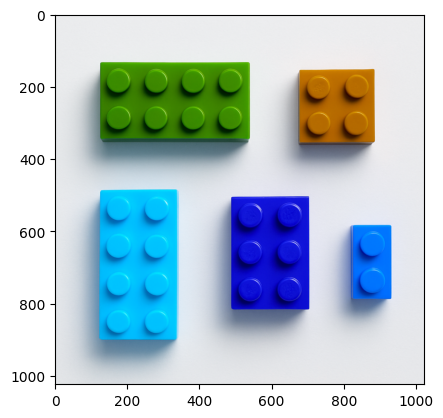

In [92]:
I = cv2.imread('Pictures/lego_2.png')
I_rgb = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)

if I is None:
    print("Error: Could not load image. Check file path and format.")
    exit()
    
plt.imshow(I)
plt.show()

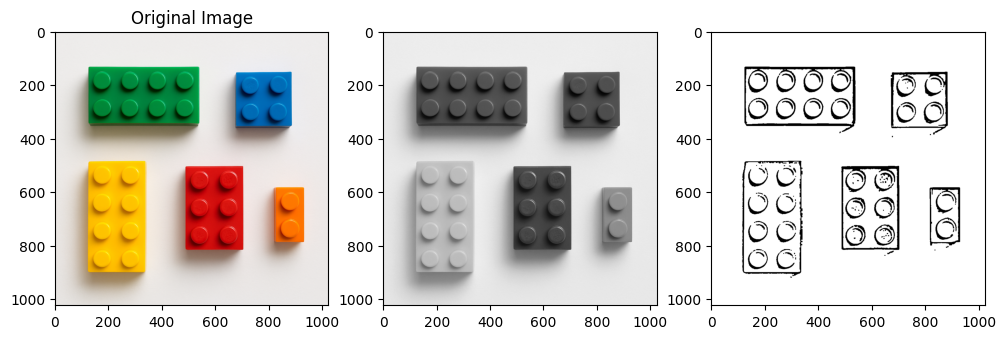

In [93]:
#Grayscale for thresholding

I_gray = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
I_blur = cv2.GaussianBlur(I_gray, (5, 5), 0)  

B = cv2.adaptiveThreshold(
    I_blur, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    19, 2
)

#Morphology
kernel = np.ones((3,3), np.uint8)
B_clean = cv2.morphologyEx(B, cv2.MORPH_CLOSE, kernel)
B_clean = cv2.morphologyEx(B_clean, cv2.MORPH_OPEN, kernel)

# Invert so LEGO = white, background = black
B_inverted = cv2.bitwise_not(B_clean)


plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1,3,2)
plt.imshow(I_gray, cmap='gray')

plt.subplot(1,3,3)
plt.imshow(B_inverted, cmap='gray')
plt.show()

In [94]:
#test commit :)

Detected 6 LEGO pieces.


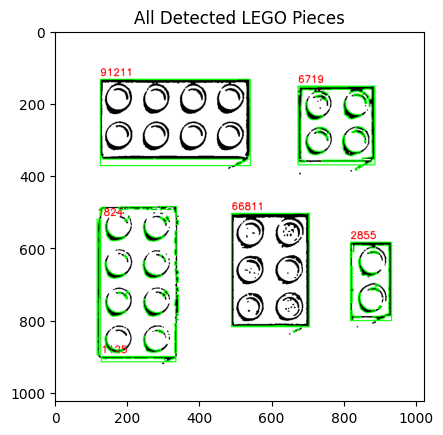

In [ ]:
#Automatically detect lego pieces

_, thresh = cv2.threshold(B_inverted, 100, 255, cv2.THRESH_BINARY_INV)

k = np.ones((5,5), np.uint8)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, k)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, k)

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

output = cv2.cvtColor(B_inverted, cv2.COLOR_GRAY2BGR)

filtered_contour = []
for c in contours:
    area = cv2.contourArea(c)
    if area > 1000:
        filtered_contour.append(c)
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(output, (x,y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(output, f"{int(area)}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
        
print(f"Detected {len(filtered_contour)} LEGO pieces.")

cv2.drawContours(output, contours, -1, (0,255,0), 2)

plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("All Detected LEGO Pieces")
plt.show()


Detected circles: 2
Detected circles: 8


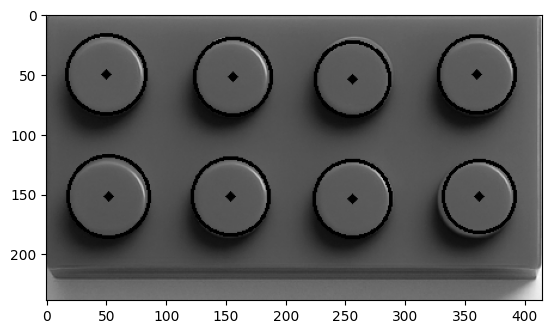

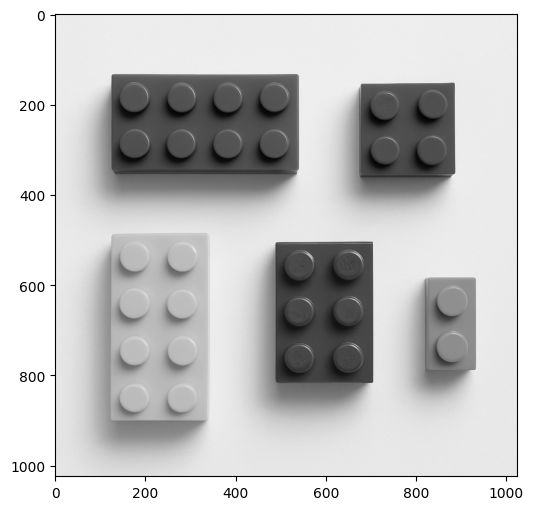

In [96]:
#Finding circles in the lego shape 
piece_count = 0

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    lego_piece = I_gray[y:y+h, x:x+w]
    piece_count += 1


    output = lego_piece.copy()
    C_cleaned = cv2.medianBlur(lego_piece, 5)

    circles = cv2.HoughCircles(
        C_cleaned,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=100,
        param1=100,
        param2=40,
        minRadius=30,
        maxRadius=60
    )

    if circles is not None:
        circles = np.uint16(np.around(circles))
        count = circles.shape[1]
        print(f"Detected circles: {count}")

        for (x, y, r) in circles[0, :]:
            cv2.circle(output, (x, y), r, (0, 255, 0), 2)
            cv2.circle(output, (x, y), 2, (0, 0, 255), 3)

        plt.imshow(output, cmap='gray')

plt.figure(figsize=(12,6))
plt.imshow(I_gray, cmap='gray')
plt.show()